#### Importing Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from xgboost import plot_importance

#### Data Loading

In [3]:
filename='freMTPL2freq.csv'

Data set consist of 678013 rows (examples) and 12 columns: 

- IDpol: Policy ID (join key)

- ClaimNb: Number of claims during the exposure period

- Exposure: Length of exposure (in years), e.g. how long a customer policy was running so far. There are yearly contracts which can be renewed or not renewed. Customers can leave before if they sell the car or go to another county to live. 

- Area: Geographic area code

- VehPower: Ordered category of vehicle power

- VehAge: Vehicle age (years)

- DrivAge: Driver age (years)

- BonusMalus: 50–350 scale (<100 = bonus, >100 = malus)

- VehBrand: Car brand (categorical)

- VehGas: Fuel type (Diesel or Regular)

- Density: Population density (inhabitants/km²) of driver’s location

- Region: Policy region code

In [4]:
df=pd.read_csv(filename)

print(df.shape)
df.head()


(678013, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


In [6]:
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


#### Checking for Missing Values

There are no null values.

In [7]:
df.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

#### Checking for Duplicates

There are no duplicates.

In [8]:
print(df['IDpol'].duplicated().sum())

0


#### Sanity Checking for Numerical Columns

There are no non-logical values, all observations fall within reasonable and expected ranges for the variables.

In [9]:
print("ClaimNb < 0:", (df["ClaimNb"] < 0).sum())
print("Exposure <= 0:", (df["Exposure"] <= 0).sum())
print("VehPower < 0:", (df["VehPower"] < 0).sum())
print("VehAge < 0:", (df["VehAge"] < 0).sum())
print("VehAge > 100:", (df["VehAge"] > 100).sum())
print("DrivAge < 16:", (df["DrivAge"] < 16).sum())
print("DrivAge > 100:", (df["DrivAge"] > 100).sum())
print("BonusMalus < 50:", (df["BonusMalus"] < 50).sum())
print("BonusMalus > 350:", (df["BonusMalus"] > 350).sum())
print("Density < 0:", (df["Density"] < 0).sum())

ClaimNb < 0: 0
Exposure <= 0: 0
VehPower < 0: 0
VehAge < 0: 0
VehAge > 100: 0
DrivAge < 16: 0
DrivAge > 100: 0
BonusMalus < 50: 0
BonusMalus > 350: 0
Density < 0: 0


In [10]:
def plot_numeric_distributions(df, numeric_cols, figsize=(14, 10)):
    
    plt.figure(figsize=figsize)
    
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(3, 3, i)
        sns.histplot(df[col], kde=True, bins='sturges')
        plt.title(col)
    
    plt.tight_layout()

def show_boxplots(df, numeric_cols, figsize=(14, 10)):
    plt.figure(figsize=figsize)
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(3, 3, i)
        sns.boxplot(x=df[col])
        plt.title(col)
    plt.tight_layout()


def plot_categorical_counts(df, cat_cols, figsize=(20,10)):
    fig, axes = plt.subplots(2, 3, figsize=figsize)  
    axes = axes.flatten()  

    for i, col in enumerate(cat_cols):
        sns.countplot(x=col, data=df, ax=axes[i], order=df[col].value_counts().index, color="skyblue", edgecolor="black")
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_ylabel("Number of policies")
        axes[i].set_xlabel(col)
        axes[i].tick_params(axis='x', rotation=0)

    fig.delaxes(axes[-1])

    plt.tight_layout()


def plot_claim_rate_distribution(df):
    sns.histplot(df["ClaimRate"], bins=30, kde=True)
    plt.title("Distribution of Claim Rate (Claims per Year)")
    plt.xlabel("Claim Rate")
    plt.ylabel("Frequency")

#### Distributions

The distributions of numerical variables were analyzed to identify potential skewness, outliers, or data entry inconsistencies. ClaimNb is highly right-skewed, with most policyholders having zero or one claim - which aligns with real-world insurance data. Exposure is almost always between 0 and 1. VehAge and DrivAge show right-skewed distributions, which is expected given real-world age distributions. Majority of BonusMalus values are around 50, with some values going up to 100, but also with some outliers. Density has a long right tail, indicating a few highly populated urban regions with much higher density values.

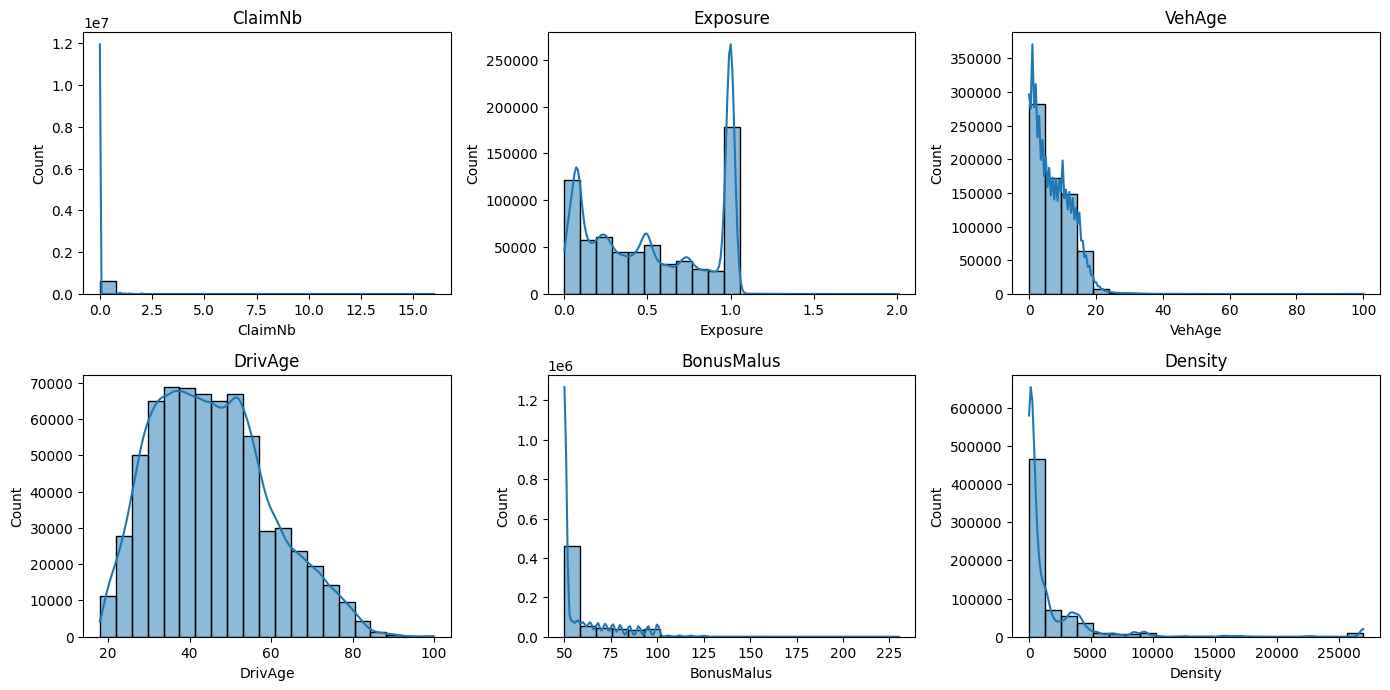

In [11]:
numeric_cols = ["ClaimNb", "Exposure", "VehAge", "DrivAge", "BonusMalus", "Density"]
plot_numeric_distributions(df, numeric_cols)

#### Boxplots

Boxplots confirm the distributional characteristics observed earlier and help visualize potential outliers.

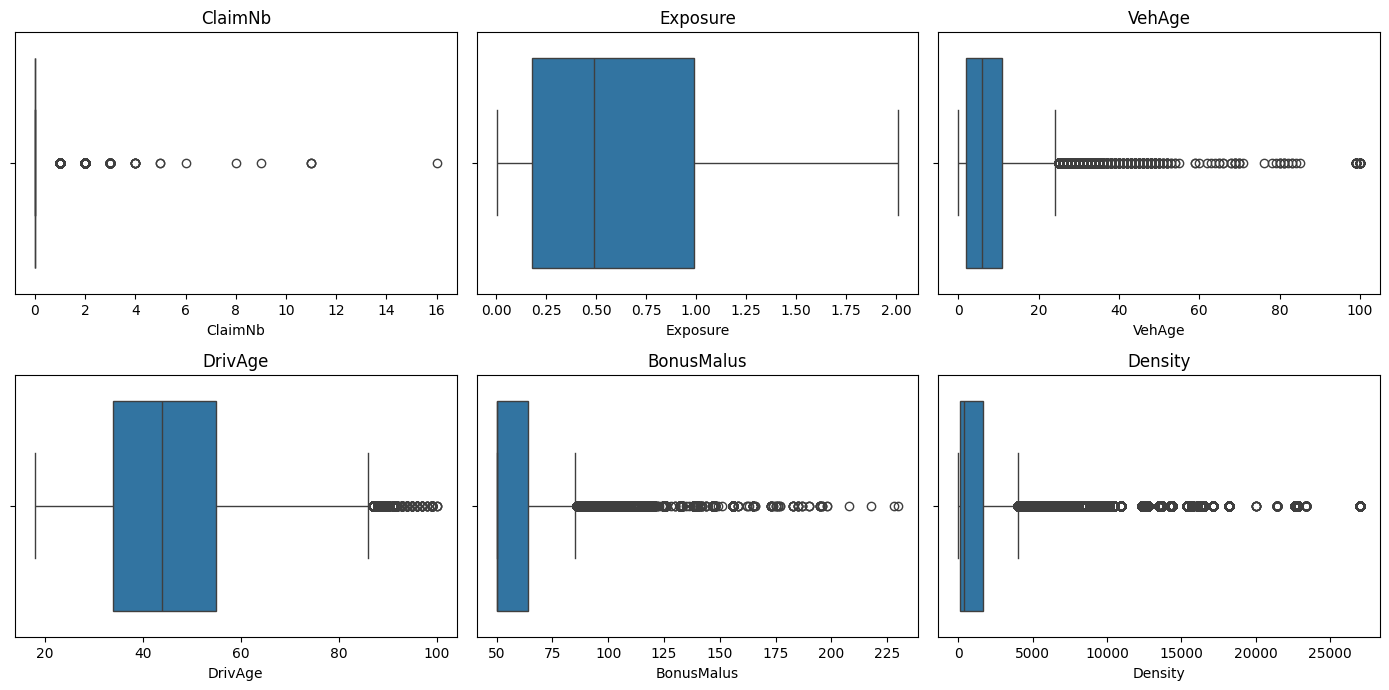

In [12]:
show_boxplots(df, numeric_cols)

#### Dealing with Outliers

Based on the previous plots, data clipping was applied to limit extreme values in several variables.

In [13]:
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["DrivAge"] = df["DrivAge"].clip(upper=85)
df["VehAge"] = df["VehAge"].clip(upper=40)

#### Categorical Columns

The categorical feature distributions show that some categories are much more frequent than others. For example, certain vehicle powers, brands, or regions dominate the dataset, which may influence model performance.

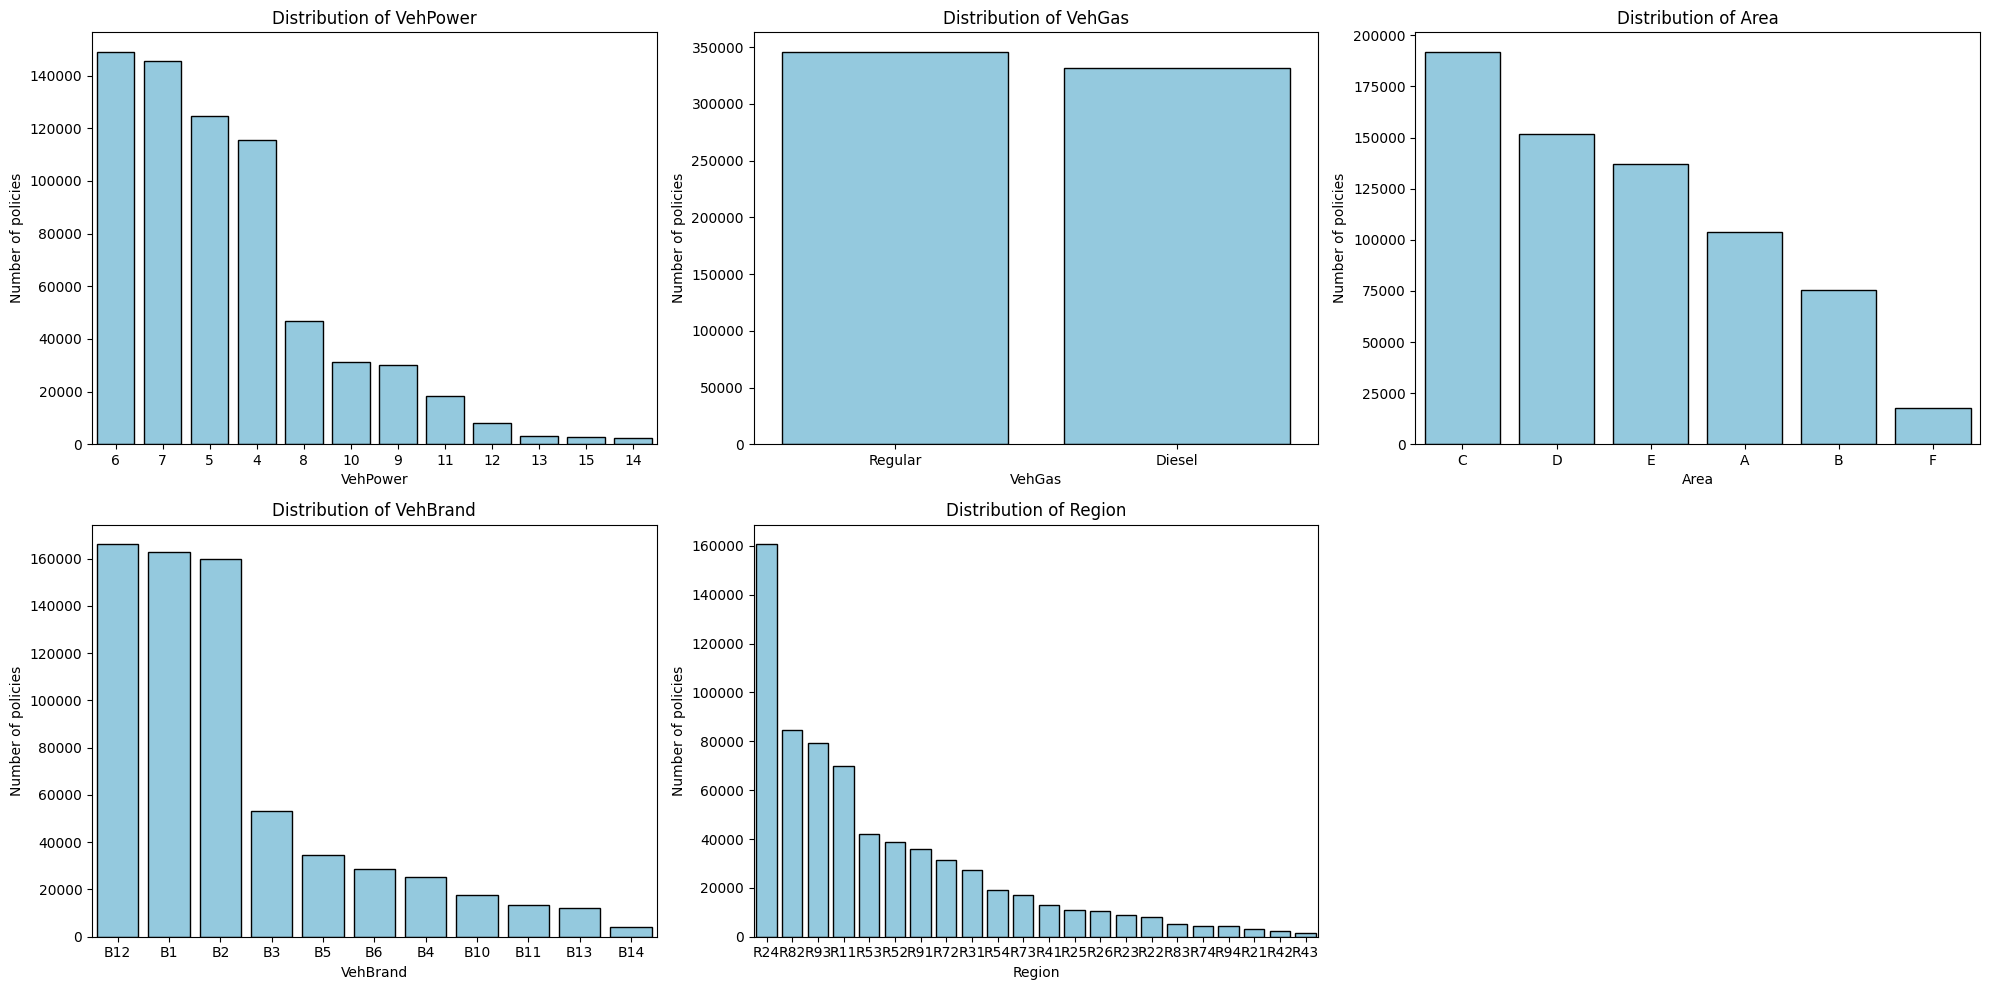

In [14]:
cat_cols = ["VehPower", "VehGas", "Area", "VehBrand", "Region"]
plot_categorical_counts(df, cat_cols)

#### How to use Exposure?

The Exposure column indicates how long a policy has been active (in years). When analyzing or modeling claims:

- Always consider claim counts relative to exposure (claims per year), not raw totals.

- In Poisson or Tweedie models, include Exposure as an offset to model the expected number of claims per unit of exposure.

- Adjusting for exposure ensures fair comparison between short-term and long-term policies and leads to more accurate risk estimates.

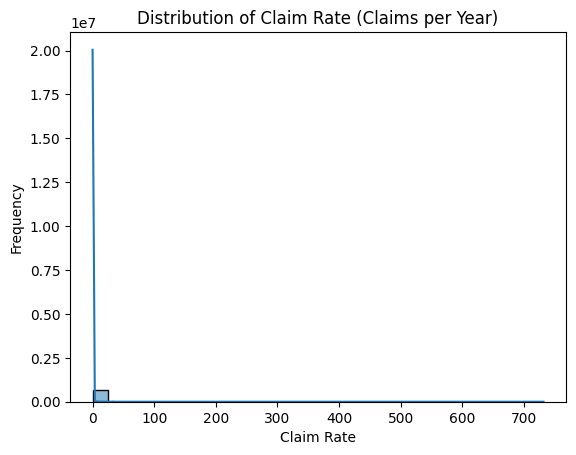

In [15]:
df["ClaimRate"] = df["ClaimNb"] / df["Exposure"]

plot_claim_rate_distribution(df)

#### Encoding of Categorical Features

Categorical variables were encoded to prepare the data for modeling. The VehPower feature was transformed using an OrdinalEncoder, while the remaining categorical features (Area, VehBrand, VehGas, and Region) were one-hot encoded using pd.get_dummies() with drop_first=True to avoid multicollinearity.

In [16]:
oe = OrdinalEncoder()
new_df=df.copy()
new_df[["VehPower"]] = oe.fit_transform(df[["VehPower"]])
new_df = pd.get_dummies(new_df, columns=["Area", "VehBrand", "VehGas", "Region"], drop_first=True)

#### Simple Decision Tree to find about Feature Importances

In [17]:
def train_poisson_tree(new_df, max_depth):

    X = new_df.drop(columns=["IDpol", "ClaimNb", "Exposure", "ClaimRate"])

    y=new_df["ClaimRate"]

    tree = DecisionTreeRegressor(
        criterion="poisson",   
        max_depth=max_depth,           
        random_state=42
    )

    tree.fit(X, y)

    return tree, X.columns


def visualize_tree(tree, feature_names):
    plt.figure(figsize=(18, 8))
    plot_tree(
        tree,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        precision=3
    )
    plt.show()

A Poisson regression tree with depth 3 was trained to identify how different features contribute to the number of claims. The resulting tree structure was visualized to better understand the most influential features.

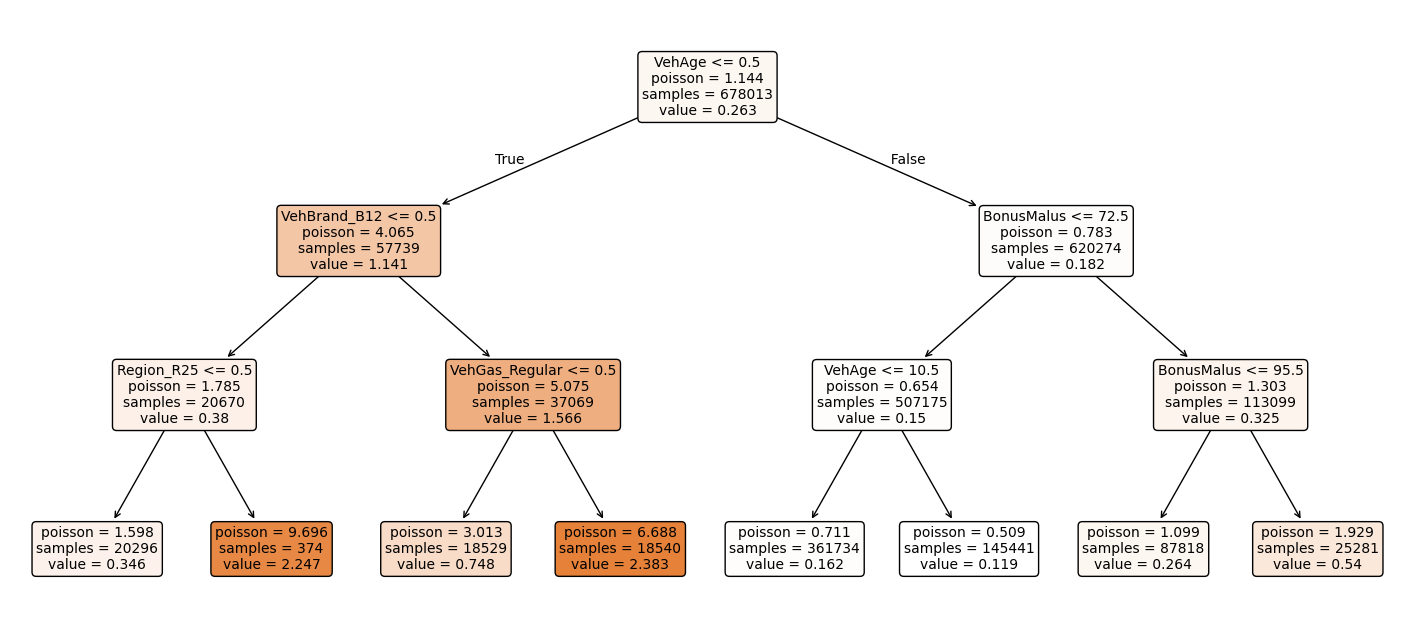

In [18]:
tree, feature_names = train_poisson_tree(new_df, 3)
visualize_tree(tree, feature_names)


#### Average ClaimRate by Features

In [19]:
def plot_avg_claim_rate_numeric(numeric_cols, df):
    plt.figure(figsize=(12, 12))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(2, 2, i)
        
        bin_edges = np.linspace(df[col].min(), df[col].max(), 15)  
        bin_edges = np.unique(np.ceil(bin_edges).astype(int))  
        
        df['bin'] = pd.cut(df[col], bins=bin_edges, include_lowest=True)
        
        mean_claim = df.groupby('bin')['ClaimRate'].mean().reset_index()
        
        sns.barplot(
            x='bin', y='ClaimRate', data=mean_claim,
            order=mean_claim['bin'],
            color="skyblue", edgecolor="black"
        )
        
        plt.title(f"Average Claim Rate by {col}")
        plt.xlabel(col)
        plt.ylabel("Average Claim Rate")
        
        ax = plt.gca()
        ax.set_xticks(range(len(mean_claim['bin'])))
        ax.set_xticklabels(
            [f"{int(interval.left)}-{int(interval.right)}" for interval in mean_claim['bin']],
            rotation=90,
            ha='right'
        )

    plt.tight_layout()
    plt.show()

    df.drop(columns='bin', inplace=True)


def plot_avg_claim_rate_cat(cat_cols, df):
    plt.figure(figsize=(15, 10))

    for i, col in enumerate(cat_cols, 1):
        plt.subplot(2, 3, i)
        
        
        mean_claim = df.groupby(col)['ClaimRate'].mean().reset_index()
        
        sns.barplot(
            x=col, y='ClaimRate', data=mean_claim,
            color="skyblue", edgecolor="black",
            order=mean_claim[col]  
        )
        
        plt.title(f"Average Claim Rate by {col}")
        plt.xlabel(col)
        plt.ylabel("Average Claim Rate")
        plt.xticks(rotation=90)

    plt.tight_layout()

The average claim rate was analyzed across selected numerical variables to examine their relationship with claim frequency. Generally, younger drivers and newer vehicles tend to have higher claim rates. Also, higher BonusMalus values correspond to more variable claim behavior.

C:\Users\mm243067m\AppData\Local\Temp\ipykernel_18256\3721505253.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_claim = df.groupby('bin')['ClaimRate'].mean().reset_index()
C:\Users\mm243067m\AppData\Local\Temp\ipykernel_18256\3721505253.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_claim = df.groupby('bin')['ClaimRate'].mean().reset_index()
C:\Users\mm243067m\AppData\Local\Temp\ipykernel_18256\3721505253.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

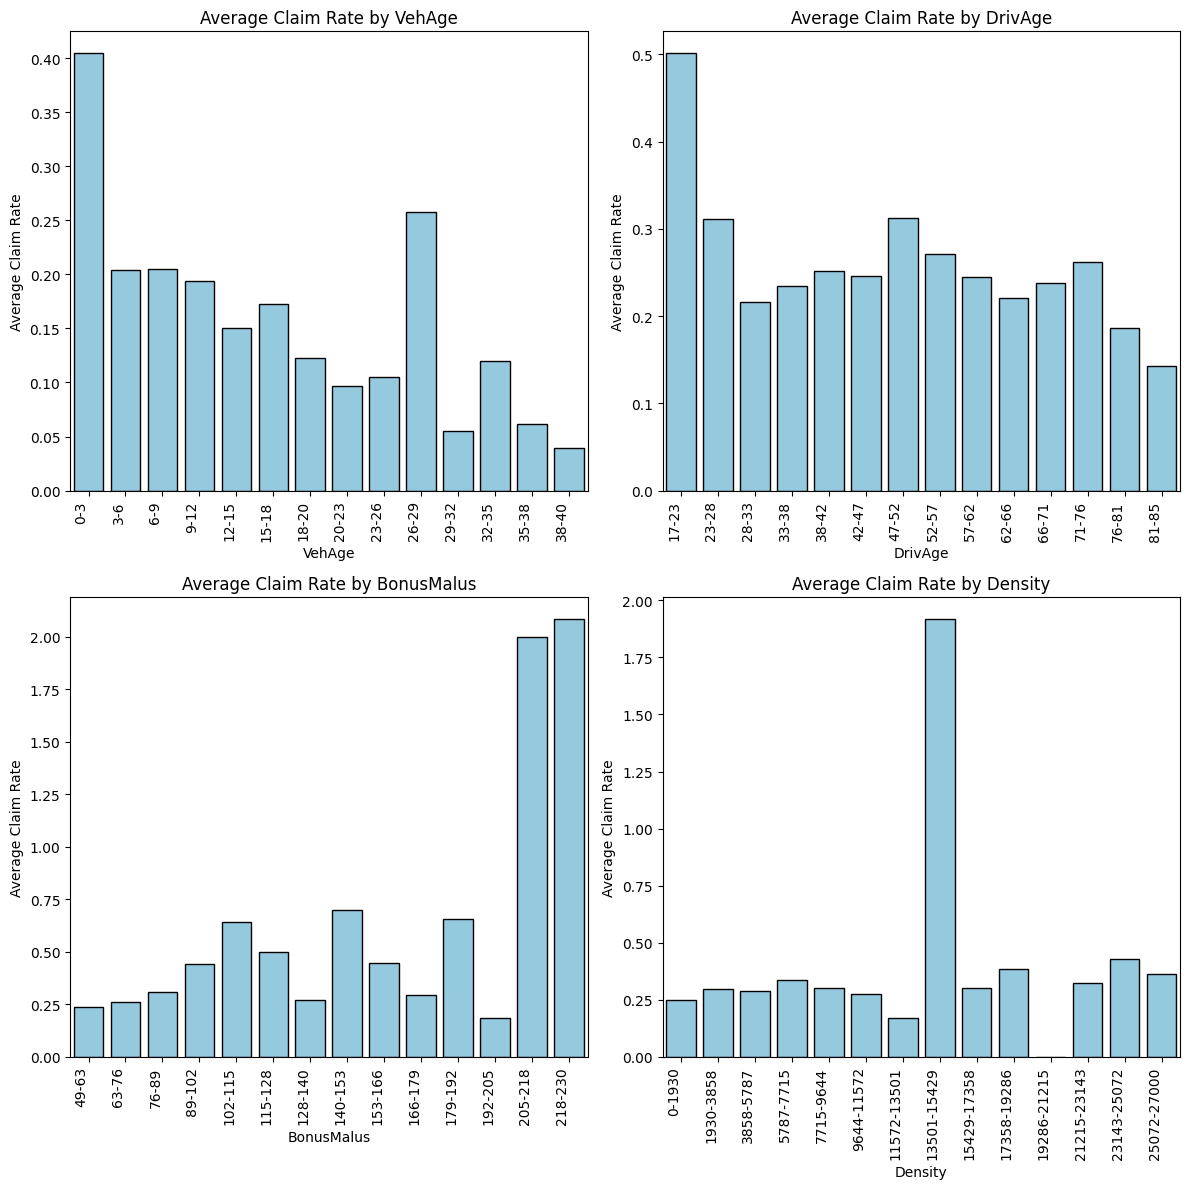

In [20]:
numeric_cols = ["VehAge", "DrivAge", "BonusMalus", "Density"]
plot_avg_claim_rate_numeric(numeric_cols, df)

The plot shows average claim rates across categorical variables. Some areas, brands, powers and regions have higher claim frequencies, highlighting the influence of these categorical factors on risk.

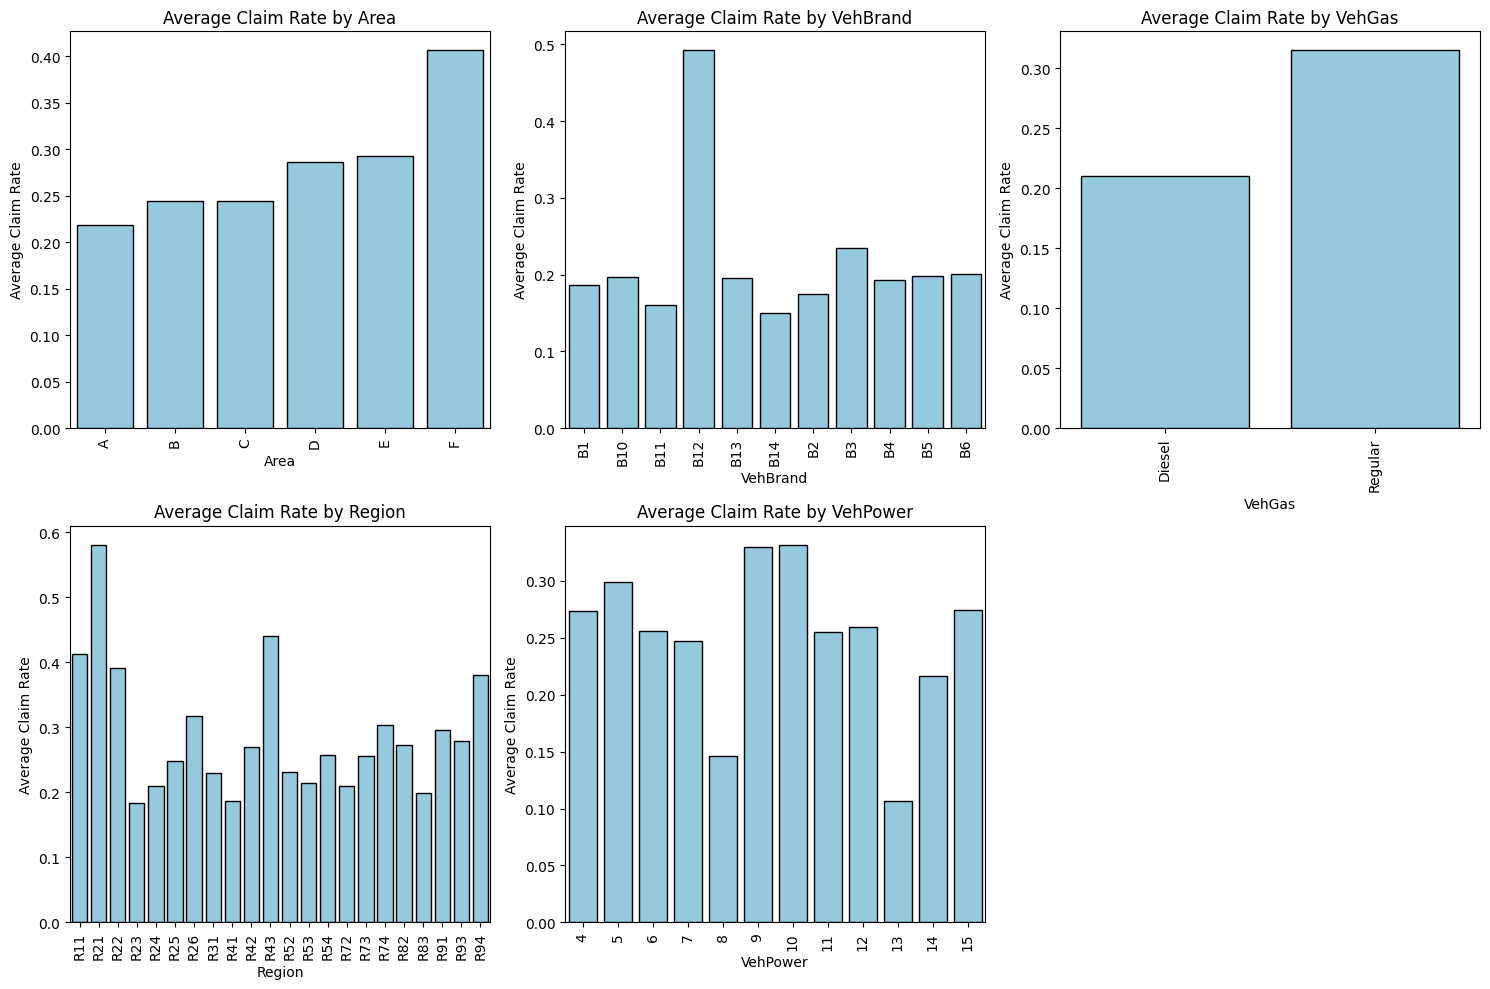

In [21]:
cat_cols = ["Area", "VehBrand", "VehGas", "Region", "VehPower"]
plot_avg_claim_rate_cat(cat_cols, df)

#### Interactions

In [22]:
def plot_claim_rate_heatmap(df, veh_col="VehAge", drv_col="DrivAge", target_col="ClaimRate", bin_size=5, figsize=(12,6)):
    df_temp = df.copy()
    
    veh_bins = np.arange(df[veh_col].min(), df[veh_col].max() + bin_size, bin_size)
    drv_bins = np.arange(df[drv_col].min(), df[drv_col].max() + bin_size, bin_size)
    
    df_temp[f'{veh_col}_bin'] = pd.cut(df[veh_col], bins=veh_bins)
    df_temp[f'{drv_col}_bin'] = pd.cut(df[drv_col], bins=drv_bins)
  
    pivot = df_temp.pivot_table(
        index=f'{drv_col}_bin',
        columns=f'{veh_col}_bin',
        values=target_col,
        aggfunc='mean'
    )
  
    plt.figure(figsize=figsize)
    sns.heatmap(
        pivot, annot=True, fmt=".2f", cmap="Reds",
        linewidths=0.5, linecolor='gray',
        cbar_kws={'label': f'Average {target_col}'}
    )
    plt.title(f"Average {target_col} by {veh_col} and {drv_col}")
    plt.xlabel("Vehicle Age")
    plt.ylabel("Driver Age")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    sns.despine(bottom=False, right=False)
    plt.tight_layout()
    plt.show()


def plot_claim_freq_by_driver_age_and_bonus_malus(df):
    df_temp = df.copy()

    df_temp['DrivAge_group'] = np.ceil(df_temp['DrivAge'] / 5) * 5
    df_temp['BonusMalusCeil'] = np.ceil(np.minimum(df_temp['BonusMalus'], 125) / 25) * 25  

    grouped = (
        df_temp
        .groupby(['DrivAge_group', 'BonusMalusCeil'], as_index=False)
        .apply(lambda g: pd.Series({
            'claim_frequency': g['ClaimNb'].sum() / g['Exposure'].sum()
        }))
    )

    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=grouped,
        x='DrivAge_group',
        y='claim_frequency',
        hue='BonusMalusCeil',
        palette='Blues',
        s=100,
        edgecolor='black'
    )
    sns.lineplot(
        data=grouped,
        x='DrivAge_group',
        y='claim_frequency',
        hue='BonusMalusCeil',
        palette='Blues',
        legend=False
    )

    plt.title("Claim Frequency by Driver Age and Bonus-Malus (clipped at 125%)")
    plt.xlabel("Driver Age (5-year groups)")
    plt.ylabel("Claim Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_bonus_malus_vehpower_heatmap(df, x_col="BonusMalus", y_col="VehPower",
                                     target_col="ClaimRate", clip_val=125, bin_size=25,
                                     figsize=(10,6)):
    df_temp = df.copy()
  
    df_temp[f'{x_col}_binned'] = np.ceil(np.minimum(df_temp[x_col], clip_val) / bin_size) * bin_size
    
    pivot = df_temp.pivot_table(
        index=y_col,
        columns=f'{x_col}_binned',
        values=target_col,
        aggfunc='mean'
    )
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        pivot, annot=True, fmt=".2f", cmap="Reds",
        linewidths=0.5, linecolor='gray',
        cbar_kws={'label': f'Average {target_col}'}
    )
    plt.title(f"Average {target_col} by {y_col} and {x_col} (clipped at {clip_val})")
    plt.xlabel(f"{x_col} (binned)")
    plt.ylabel(y_col)
    plt.xticks(rotation=95)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

The heatmap shows the average claim rate across binned driver ages and vehicle ages. Higher claim rates are observed for younger drivers with older vehicles

C:\Users\mm243067m\AppData\Local\Temp\ipykernel_18256\2100724760.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_temp.pivot_table(


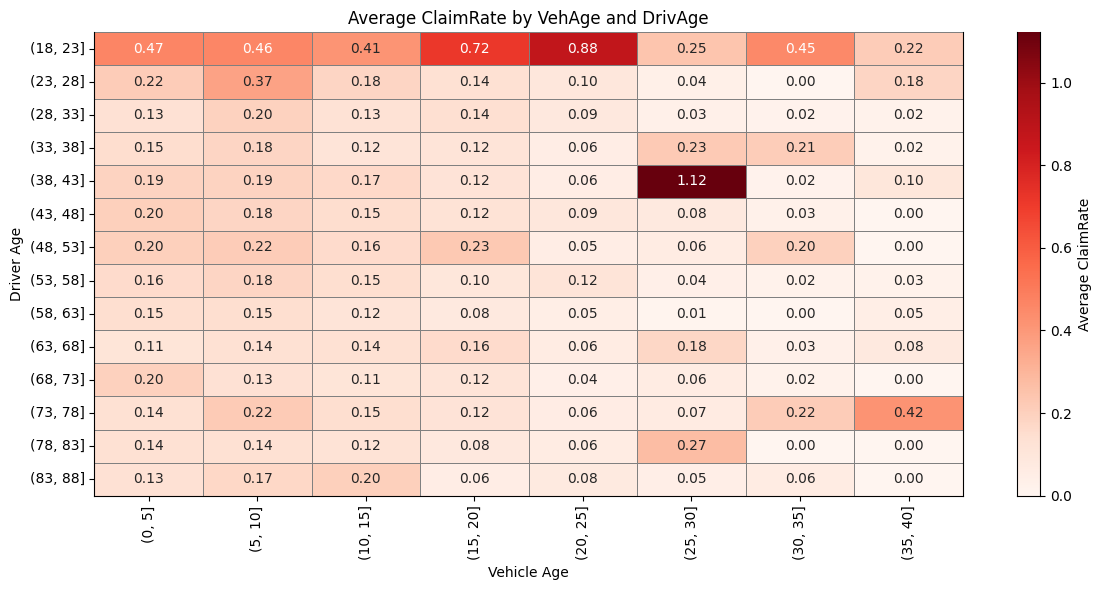

In [23]:
plot_claim_rate_heatmap(df, "VehAge", "DrivAge")

The plot shows claim frequency by binned driver age and Bonus-Malus levels (clipped at 125%). Across all Bonus-Malus categories, claim frequency is high for younger drivers, then gradually decreases with driver age, before rising again for older drivers.

C:\Users\mm243067m\AppData\Local\Temp\ipykernel_18256\2100724760.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


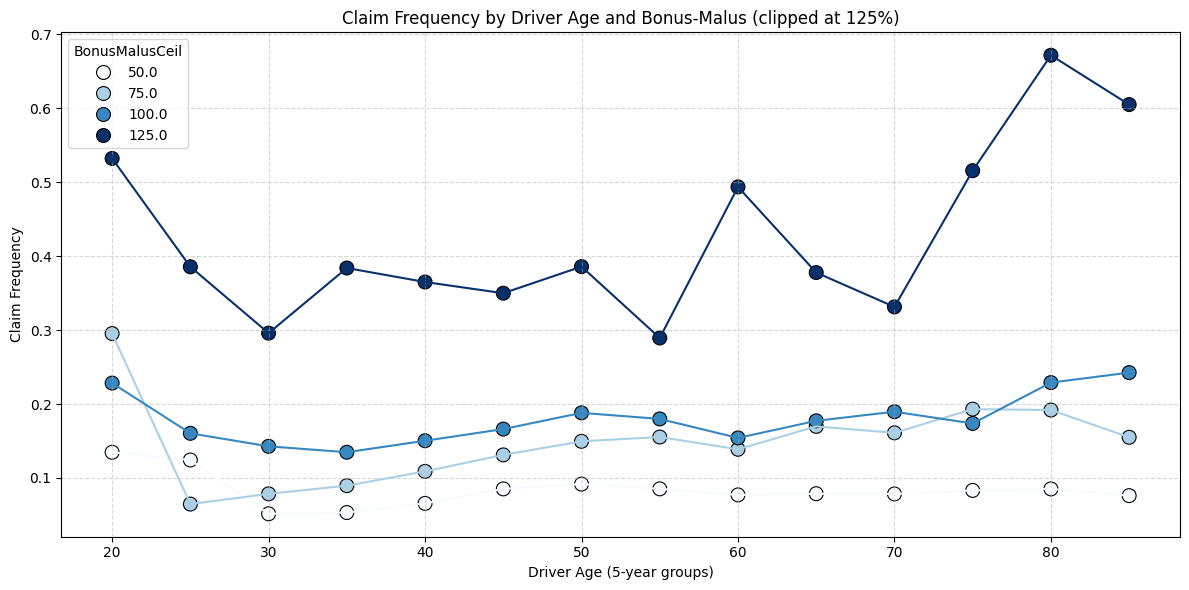

In [24]:
plot_claim_freq_by_driver_age_and_bonus_malus(df)

The heatmap displays the average claim rate across binned Bonus-Malus levels (capped at 125%) and vehicle power. Claim rate tends to increase with higher Bonus-Malus levels and is slightly higher for vehicles with greater power.

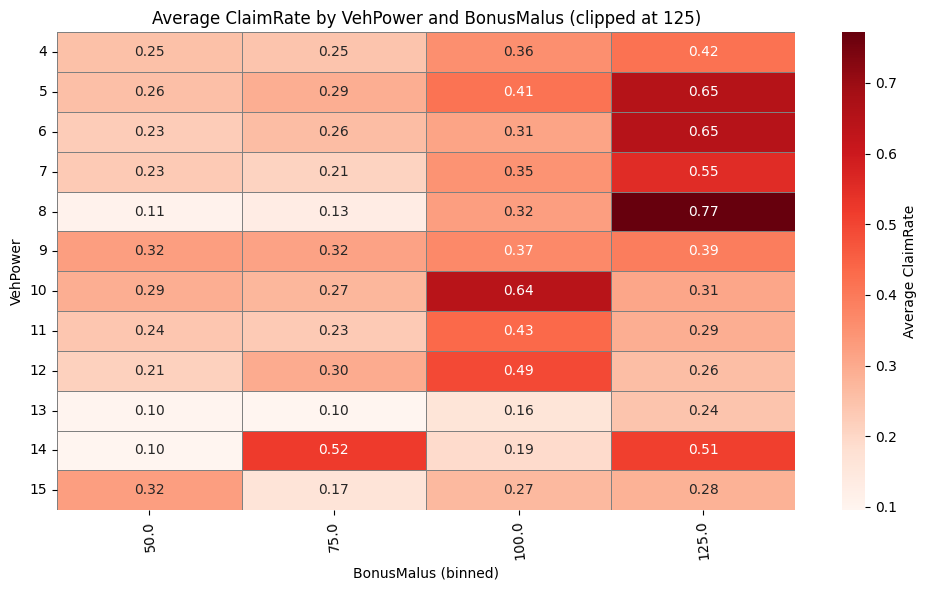

In [25]:
plot_bonus_malus_vehpower_heatmap(df)

#### Splitting data into training and test set

In [26]:
X = df.drop(columns=["IDpol", "ClaimNb", "Exposure", "ClaimRate"])
y = df["ClaimNb"]
weights = df["Exposure"]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)
print(X_train.shape)
print(X_test.shape)


(542410, 9)
(135603, 9)


#### Baseline model

In [27]:
def print_poisson_deviance(y_true, y_pred, sample_weight=None):
    deviance = mean_poisson_deviance(y_true, y_pred, sample_weight=sample_weight)
    print(f"Poisson deviance: {deviance:.4f}")
    

A baseline model was computed using the weighted mean of the training target (ClaimNb). The Poisson deviance of this constant-prediction baseline provides a reference point for evaluating more complex models.

In [28]:
baseline_rate = np.average(y_train, weights=w_train)  
baseline_pred = np.full_like(y_test, baseline_rate, dtype=float)

print_poisson_deviance(y_test, baseline_pred, w_test)

Poisson deviance: 0.3652


#### Poisson Regression

The Poisson GLM is appropriate for modeling count data, such as insurance claims, because it assumes that the target variable follows a Poisson distribution. By including Exposure as a weight, the model accounts for varying policy exposure times, ensuring that policies with longer exposure contribute proportionally more to the likelihood. This allows the model to estimate the expected claim count per unit of exposure accurately. 

In [29]:
def prepare_data(X_train, y_train, w_train, X_test, y_test, w_test):
    train_df = X_train.copy()
    train_df["ClaimNb"] = y_train
    train_df["Exposure"] = w_train

    test_df = X_test.copy()
    test_df["ClaimNb"] = y_test
    test_df["Exposure"] = w_test

    return train_df, test_df

def train_glm_poisson(train_df, test_df, formula):

    glm_poisson = smf.glm(
        formula=formula,
        data=train_df,
        family=sm.families.Poisson(),
        freq_weights=train_df['Exposure']
    ).fit()

    y_pred_train = glm_poisson.predict(train_df)
    y_pred_test = glm_poisson.predict(test_df)

    return glm_poisson, y_pred_train, y_pred_test


def plot_glm_feature_importance(glm_model, top_n=5):

    coefs = glm_model.params.drop("Intercept", errors='ignore')
   
    exp_coefs = np.exp(coefs)
    
    feature_map = [name.split('[')[0] for name in coefs.index]
    
    importance_df = pd.DataFrame({
        "feature": feature_map,
        "exp_coef": exp_coefs.values
    })
    
    importance_df = importance_df.groupby("feature")["exp_coef"] \
                                 .mean() \
                                 .sort_values(key=lambda x: np.abs(x-1), ascending=False) \
                                 .to_frame()
    
    top_features = importance_df.iloc[:top_n]
    
    plt.figure(figsize=(8,6))
    plt.barh(top_features.index, np.abs(top_features['exp_coef'] - 1), color='skyblue')
    plt.xlabel('|exp(coef) - 1|')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def get_top_10_errors(X_test, y_test, y_pred):
    error_df = X_test.copy()
    error_df["y_true"] = y_test
    error_df["y_pred"] = y_pred
    error_df["abs_error"] = np.abs(y_test - y_pred)

    top_errors = error_df.sort_values(by="abs_error", ascending=False).head(10)
    print(top_errors)

A Poisson GLM was trained using all features without interaction terms, with Exposure included as a weight. The resulting model achieved a performance slightly better than the baseline, indicating that the features provide some predictive power for the claim counts.

In [30]:
train_df, test_df = prepare_data(X_train, y_train, w_train, X_test, y_test, w_test)

glm_poisson, y_pred_train, y_pred_test = train_glm_poisson(train_df, test_df, "ClaimNb ~ BonusMalus + " \
"DrivAge + VehAge + VehPower + Density + C(Area) + C(VehBrand) + C(VehGas) + C(Region)")

print(glm_poisson.summary())
print("Training:")
print_poisson_deviance(y_train, y_pred_train, w_train)
print("Test:")
print_poisson_deviance(y_test, y_pred_test, w_test)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542410
Model:                            GLM   Df Residuals:                286720.91
Model Family:                 Poisson   Df Model:                           42
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68415.
Date:                Sun, 12 Oct 2025   Deviance:                   1.0127e+05
Time:                        03:28:44   Pearson chi2:                 2.99e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005605
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.7623 

#### Feature Importances

The top 5 most important features according to the GLM Poisson model are displayed in the feature importance plot. Interestingly, 4 of these features - VehAge, DrivAge, BonusMalus, and VehPower were also identified as important in the previously visualized Poisson regression tree, confirming their consistent influence on claim counts.

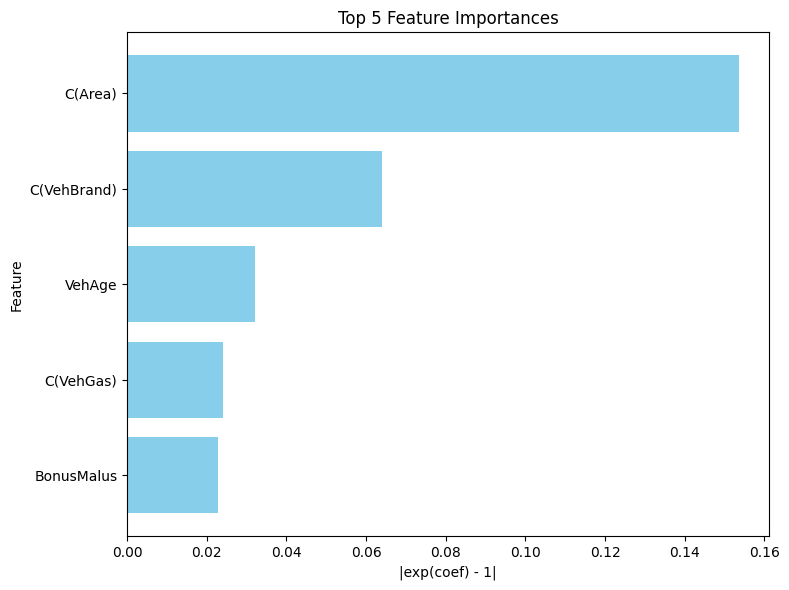

In [31]:
plot_glm_feature_importance(glm_poisson)

#### Top 10 Errors

The top 10 prediction errors are examined to identify cases where the model deviates most from the observed claim counts. These errors highlight specific combinations of features that the model struggles to predict accurately, providing insights for potential refinements, such as introducing interaction terms, handling outliers, or considering additional explanatory variables.

The top 10 errors mostly occur for observations with high claim counts. This is expected in insurance claim modeling, as rare high-claim cases are inherently harder to predict accurately. These errors suggest that the current model may benefit from incorporating interaction terms or additional features to better capture the patterns for these extreme cases.

In [32]:
get_top_10_errors(X_test, y_test, y_pred_test)

       Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density  \
304484    D         4      12       52          50       B1  Regular      824   
364437    E         5       9       23          90       B3   Diesel     6924   
795       C         4       0       44          50      B12  Regular      175   
630041    D         6       7       52          50       B2   Diesel      645   
185528    E         5       6       35          57       B1  Regular     3317   
535261    E         5      15       62          60       B2   Diesel     3095   
497569    F         8       2       53          52      B12   Diesel    15725   
65055     B         4      10       54          62       B1  Regular       84   
7154      C         6       0       41          50       B1  Regular      270   
41661     C         5       1       37          61       B3   Diesel      213   

       Region  y_true    y_pred  abs_error  
304484    R91       4  0.039234   3.960766  
364437    R11     

#### Poisson Regression with Interactions

A Poisson GLM with interaction terms was also tested, including VehAge:C(DrivAge_group), C(DrivAge_group):BonusMalus, and VehPower:BonusMalus. However, the improvement over the previous model without interactions was minimal, indicating that these interactions only slightly enhance predictive performance in this dataset.

In [33]:
bins = [18, 21, 26, 31, 41, 51, 71, 101]  
labels = [1, 2, 3, 4, 5, 6, 7]

train_df['DrivAge_group'] = pd.cut(train_df['DrivAge'], bins=bins, labels=labels, right=False)
test_df['DrivAge_group'] = pd.cut(test_df['DrivAge'], bins=bins, labels=labels, right=False)

glm_poisson, y_pred_train, y_pred_test = train_glm_poisson(train_df, test_df, """
ClaimNb ~ C(Area) + C(VehBrand) + C(VehGas) + C(Region)
         + BonusMalus + C(DrivAge_group) + VehAge + VehPower + Density
         + VehAge:C(DrivAge_group) + C(DrivAge_group):BonusMalus + VehPower:BonusMalus
""")

print(glm_poisson.summary())
print("Training:")
print_poisson_deviance(y_train, y_pred_train, w_train)
print("Test:")
print_poisson_deviance(y_test, y_pred_test, w_test)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542410
Model:                            GLM   Df Residuals:                286702.91
Model Family:                 Poisson   Df Model:                           60
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68291.
Date:                Sun, 12 Oct 2025   Deviance:                   1.0102e+05
Time:                        03:29:17   Pearson chi2:                 2.98e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.006059
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

#### Feature Importances

Among the top 5 most important features identified in the GLM with interactions, 4 of them are the same as those in the previous model without interactions, though their ranking order has slightly changed.

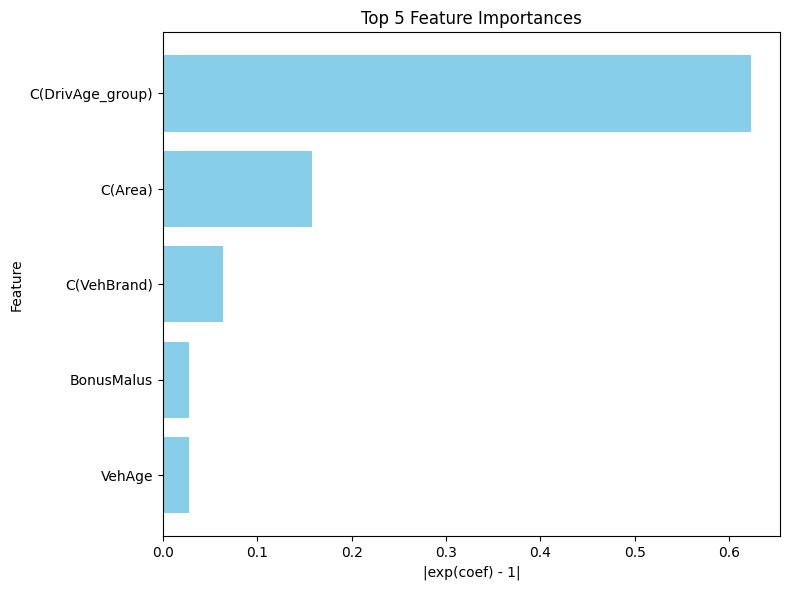

In [34]:
plot_glm_feature_importance(glm_poisson)

#### Top 10 errors

When examining the top 10 errors, some of the same examples appear as in the previous model. This suggests that additional nonlinear transformations or alternative models like XGBoost could be explored to better capture these patterns.

In [35]:
get_top_10_errors(X_test, y_test, y_pred_test)

       Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density  \
304484    D         4      12       52          50       B1  Regular      824   
364437    E         5       9       23          90       B3   Diesel     6924   
18711     C         7      12       60         228       B1  Regular      300   
795       C         4       0       44          50      B12  Regular      175   
185528    E         5       6       35          57       B1  Regular     3317   
535261    E         5      15       62          60       B2   Diesel     3095   
630041    D         6       7       52          50       B2   Diesel      645   
497569    F         8       2       53          52      B12   Diesel    15725   
65055     B         4      10       54          62       B1  Regular       84   
510386    D         9      10       34          78      B13   Diesel     1090   

       Region  y_true    y_pred  abs_error  
304484    R91       4  0.042690   3.957310  
364437    R11     

#### XGBoost

An XGBoost model with a Poisson objective was trained to predict claim counts, using exposure as sample weights.

In [36]:
X = new_df.drop(columns=["IDpol", "ClaimNb", "Exposure", "ClaimRate"])
y = new_df["ClaimNb"]
weights = new_df["Exposure"]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    objective='count:poisson',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred = xgb_model.predict(X_test)
print_poisson_deviance(y_test, y_pred, w_test)

Poisson deviance: 0.3435


The previous model already showed better performance than the GLM, so hyperparameter tuning was performed to investigate whether further improvements could be achieved. Hyperparameter tuning was performed using Random Search with 5-fold cross-validation to explore a range of parameter combinations and evaluate model performance more robustly. This led to a slightly improved result compared to the previous XGBoost model.

In [37]:
model = xgb.XGBRegressor(
    objective="count:poisson",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "max_depth": [3, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 300, 400, 500],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False, 
                              sample_weight=w_train)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,          
    scoring=poisson_scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train, sample_weight=w_train)

print("Best params:", random_search.best_params_)
print("Best Poisson deviance (CV):", -random_search.best_score_)

best_model = random_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_deviance = mean_poisson_deviance(y_test, y_pred_test, sample_weight=w_test)
print("Test Poisson deviance:", test_deviance)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best Poisson deviance (CV): 0.3409264259629228
Test Poisson deviance: 0.34329864157992845


#### Feature Importances

The top 5 features identified by the XGBoost model are similar to those from the GLM, with the main difference being that BonusMalus is now the most important feature.

<Figure size 800x600 with 0 Axes>

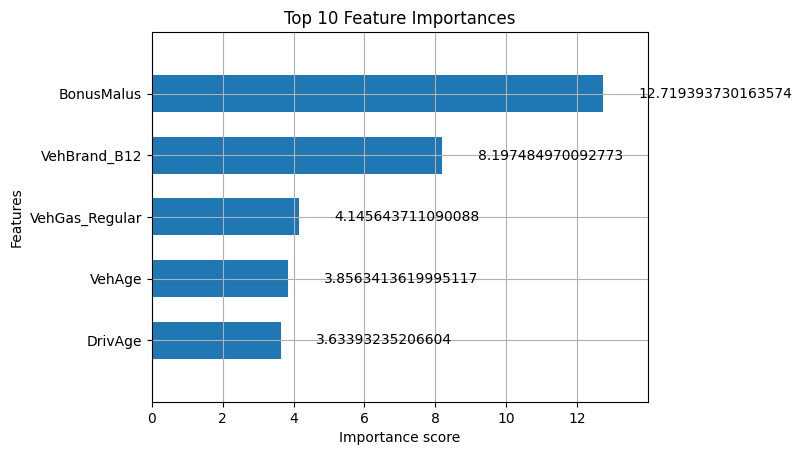

In [38]:
plt.figure(figsize=(8,6))
plot_importance(best_model, max_num_features=5, importance_type='gain', height=0.6)
plt.title("Top 10 Feature Importances")
plt.show()

#### Top 10 Errors

The top 10 errors mostly occur for policies with high claim counts, which is expected in this type of insurance dataset. Some of the examples are the same as in the GLM model. Potential refinements could include introducing additional nonlinear transformations of features, exploring new interaction terms, or further tuning the XGBoost hyperparameters to better capture these extreme cases.

In [39]:
get_top_10_errors(X_test, y_test, y_pred_test)

        VehPower  VehAge  DrivAge  BonusMalus  Density  Area_B  Area_C  \
304484       0.0      12       52          50      824   False   False   
364437       1.0       9       23          90     6924   False   False   
185528       1.0       6       35          57     3317   False   False   
7154         2.0       0       41          50      270   False    True   
497569       4.0       2       53          52    15725   False   False   
535261       1.0      15       62          60     3095   False   False   
630041       2.0       7       52          50      645   False   False   
214606       0.0      10       24          90     1955   False   False   
4808         0.0       1       28         100     3339   False   False   
41661        1.0       1       37          61      213   False    True   

        Area_D  Area_E  Area_F  ...  Region_R73  Region_R74  Region_R82  \
304484    True   False   False  ...       False       False       False   
364437   False    True   False  ...

#### Conclusion

Both the GLM and XGBoost models achieve lower deviance values compared to baseline model, indicating somewhat improved predictions over the baseline. XGBoost achieved slightly better performance, while feature importance rankings are largely consistent between models. High errors are concentrated on policies with large claim counts, suggesting that further refinements could focus on nonlinear effects and interactions. Overall, the workflow demonstrates the value of combining exploratory analysis, feature engineering, and model comparison in actuarial modeling.